**PAQUETERIAS NECESARIAS**

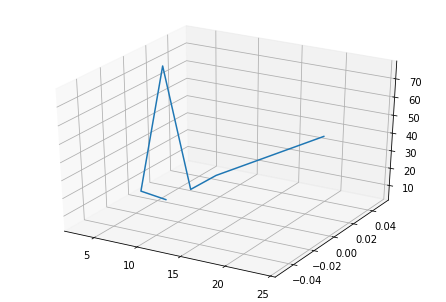

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure()
ax = Axes3D(fig)

x = [6,3,6,9,12,24]
y = [3,5,78,12,23,56]
# put 0s on the y-axis, and put the y axis on the z-axis
surf = ax.plot(xs=x, ys=[0]*len(x), zs=y, zdir='z', label='ys=0, zdir=z')
plt.show(surf)

In [1]:
## INCLUYE TODOS LOS PAQUETES A USAR
import tensorflow as tf
import random
from tensorflow import keras
 # Bibliotecas de ayuda
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import gaussian
 # Biblioteca para datos de entrenamiento
from sklearn.model_selection import train_test_split
import h5py as h # manipular extensiones
# FUNCIONES DEFINIDAS PARA USO NECESARIO
import timeit
import PAQ

**ENTRADA DE LA INFORMACION, ORDENAMIENTO DE LA INFORMACION A USAR**

In [2]:
 # ENTRAR LA INFORMACION DESDE UN ARCHIVO EXTERNO
FILE  = h.File("DATOS/TODOS.h5", 'r')
INPUT = np.vstack([FILE["qcd/images"][:], FILE["wprime/images"][:]]); INPUT=INPUT/np.max(INPUT) # SE NORMALIZA
LABEL = np.hstack([FILE["qcd/labels"][:], FILE["wprime/labels"][:]])
OUTPUT_LINEAL = np.ones((len(LABEL), 2));
OUTPUT_LINEAL[:,0] = LABEL < 1    ;     OUTPUT_LINEAL[:,1] = LABEL > 0
 # REACONDICIONAR LA INFORMACION INPUT EN UNA MATRIX PARA SU RAPIDO ACCESO
INPUT_LINEAL = np.reshape(INPUT, [len(INPUT),-1]) # LA INFORMACION SE LINEALIZA Y SE LOCALIZA EN LAS FILAS
 # SEPARAR LA INFO PARA ENTRENAR DE LA QUE SERA USADA PARA EL TEST DE CORRESPONDENCIA
INPUT_LINEAL, INPUT_LINEAL_TEST, OUTPUT_LINEAL, OUTPUT_LINEAL_TEST = train_test_split( 
    INPUT_LINEAL, OUTPUT_LINEAL, test_size=0.2, shuffle = True);

**PARAMETROS INICIALES DE ENTRENAMIENTO**

In [3]:
## CLASE DE LOS VALORES A TENER EN CUENTA
'''class arreglo():
    def __init__( self , v_input ):#, exp = 1 , cross_entropy = 1, n_iterations = 3000, dropout = 0.5):
        self.n_capas  = 2;         self.v_output = 2;         self.v_input = v_input 
        self.exp      = 1;
        #self.matrix_neuronas = {}
        self.learning_rate = 1e-1; self.cross_entropy = 1;    self.n_iterations  = 3000;
        self.dropout       = 0.5;
        self.n_step_visual_process = 10;'''
## CLASE DE LOS VALORES A TENER EN CUENTA
config = tf.compat.v1.placeholder("float")
config.v_input= len(INPUT_LINEAL[0,:]); config.v_output = len(OUTPUT_LINEAL[0,:]);#, exp = 1 , cross_entropy = 1, n_iterations = 3000, dropout = 0.5):
config.n_capas  = 2;                    config.exp      = 1;
#self.matrix_neuronas = {}
config.learning_rate = 1e-1; config.cross_entropy = 1;    config.n_iterations  = 3000;
config.dropout       = 0.5;
config.n_step_visual_process = 10;

In [4]:
'''# def neuronas(v_input, v_output, n_capas , exp ):
def neuronas(v_input, v_output, exp = 1, n_capas = 2, modo = 'poly' ):
    x = np.ones(n_capas + 2)
    if  exp >= 1: #modo == 'poly':
        for i in range(n_capas + 2):
            x[len(x)-i-1] = round(( v_input - v_output )*pow(i/(n_capas + 1 ), exp) + v_output)
            #print(x[i])
            #print(i)
    elif exp < 1:
        for i in range(n_capas + 2):
            x[len(x)-i-1] = round(( v_input - v_output )*pow(i/(n_capas + 1 ), 1/exp) + v_output)
            #print(x[i])
            #print(i)
    return x'''
## DEFINICION DE LOS MODOS DE ELECCION DE CAPAS OCULTAS Y NUMEROS DE NEURONAS
def neuronas( config ): #v_input, v_output, n_capas = 2, exp = 1,  modo = 'poly' ):
    #config = Dd()
    x = np.ones(config.n_capas + 2)
    #print(x)
    if  config.exp >= 1: #modo == 'poly':
        for i in range(config.n_capas + 2):
            x[len(x)-i-1] = round(( config.v_input - config.v_output )*pow(i/(config.n_capas + 1 ), config.exp) + config.v_output)
            #print(x[i])
            #print(i)
    elif config.exp < 1:
        for i in range(config.n_capas + 2):
            x[len(x)-i-1] = round(( config.v_input - config.v_output )*pow(i/( config.n_capas + 1 ), -1/config.exp) + config.v_output)
            #print(x[i])
            #print(i)
    config.matrix_neuronas = np.int64(x)
    return config

In [5]:
# print(neuronas(100,2,3))
config = neuronas(config)
n = config.matrix_neuronas
#print(n)
#config.n_iterations = 3000   ;   dropout = 0.5
 # print(range(len(n)-1))

In [6]:
X = tf.compat.v1.placeholder("float", [None, n[0]], name = "Estructura_X"); # Estructura de la entrada
print(X)

Tensor("Estructura_X:0", shape=(?, 625), dtype=float32)


In [7]:
#del Y
#print(Y)

In [8]:
#del Y
Y = tf.compat.v1.placeholder("float", [None, n[len(n)-1]], name = "Placeholder_y") #Estructura de la salida
print(Y)

Tensor("Placeholder_y:0", shape=(?, 2), dtype=float32)


In [9]:
for i in range(len(n)-1):
    #print(n[i])
    #print(i)
    weights = tf.Variable(tf.truncated_normal([n[i], n[i+1]], stddev=0.1), name=f"w{i}")
    biases = tf.Variable(tf.constant(0.1, shape=[n[i+1]]), name=f"b{i}")
    if  i==0: # CONDICION INICIAL
        
        layer = tf.add(tf.matmul(X, weights), biases, name=f"layer{i}")
    #elif i==len(n)-2: # CONDICION FINAL
    #    print(tf.add(tf.matmul(layer, weights),biases))
    #    layer = tf.matmul(layer, weights) + biases  
    else: # VALORES INTERNMEDIOS
        layer = tf.add(tf.matmul(layer, weights), biases, name=f"layer{i}")

In [10]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=layer))
train_step = tf.compat.v1.train.AdamOptimizer(config.learning_rate).minimize(cross_entropy)

correct_pred = tf.equal(tf.argmax(layer, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

**INICIALIZAR EL ENTRENAMIENTO**

In [11]:
init = tf.compat.v1.global_variables_initializer()

**ENTRENAMIENTO**

In [12]:
cost_summary = tf.compat.v1.summary.scalar("Cost", cross_entropy)
acc_summary = tf.compat.v1.summary.scalar("Accuracy", accuracy)
all_summary = tf.compat.v1.summary.merge_all()#'''

In [13]:
#saver=tf.train.Saver() #SALVAR LA SECCION PARA PODERLA UTILIZAR LUEGO
with tf.Session() as sess:
    writer = tf.summary.FileWriter("Tensorboard", sess.graph)
    #print(sess)
    sess.run(init)
    #saver.save(sess, 'modelo')
    for i in range(config.n_iterations):
        sess.run(train_step, feed_dict={X: INPUT_LINEAL, Y:OUTPUT_LINEAL}) # CORRIDA
        
        summary_results, loss, acc = sess.run([all_summary, cross_entropy, accuracy], feed_dict={X: INPUT_LINEAL, Y: OUTPUT_LINEAL})
        writer.add_summary(summary_results, i)
        if (i)%10 == 0:
            print("Iteration", str(i), "\t| Loss =", str(loss), "\t| Accuracy =", str(acc))
    
        if acc>.70:
            print("Iteration", str(i), "\t| Loss =", str(loss), "\t| Accuracy =", str(acc))
            break
    test_accuracy = sess.run(accuracy, feed_dict={X: INPUT_LINEAL_TEST, Y: OUTPUT_LINEAL_TEST})
    print("\nAccuracy on test set:", test_accuracy)
    
    a, b = sess.run([tf.argmax(layer, 1),tf.argmax(Y,1)], feed_dict={X: INPUT_LINEAL, Y: OUTPUT_LINEAL}) 
    
    for ea, eb in zip(a, b):
        print(ea,eb)
    #saver.save(sess, 'modelo') #SALVAR EL MODELO EXTERNAMENTE'''

Iteration 0 	| Loss = 33.282265 	| Accuracy = 0.4006859
Iteration 4 	| Loss = 0.38185695 	| Accuracy = 0.9134991

Accuracy on test set: 0.9070476
1 1
1 1
1 1
0 1
0 0
1 1
0 0
0 0
0 0
1 1
1 1
1 1
1 1
0 0
0 0
0 1
0 1
0 0
0 0
1 1
1 1
0 0
1 1
1 1
1 1
0 0
0 0
0 0
1 1
0 0
1 1
0 0
1 1
1 1
0 0
1 1
0 0
1 1
0 0
1 1
0 1
1 1
1 1
0 0
0 1
1 1
1 1
0 0
0 0
1 1
1 1
1 1
1 1
0 0
0 0
0 0
0 0
1 1
1 1
0 0
1 1
0 1
0 0
0 0
1 1
0 0
0 1
0 0
1 1
0 1
1 1
1 1
1 1
0 0
1 1
1 1
0 0
0 0
1 1
1 1
0 0
1 1
1 1
1 1
1 1
1 1
1 1
0 0
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 0
1 1
0 0
0 0
1 1
1 1
1 1
0 0
0 1
1 1
1 1
1 0
1 1
0 0
1 1
1 1
0 0
1 1
1 1
0 0
1 1
0 0
0 0
0 0
0 0
0 0
0 0
1 1
1 1
1 1
1 1
0 1
1 1
1 1
0 0
0 1
1 1
1 1
0 1
0 0
1 1
1 1
1 1
1 1
1 1
0 0
1 1
1 1
0 0
0 0
1 1
1 1
1 1
1 1
1 1
0 0
1 1
1 1
0 1
1 1
0 0
1 1
1 1
1 1
1 1
1 1
0 1
0 0
0 0
1 1
1 1
0 0
1 1
1 1
0 0
1 1
0 0
1 1
1 1
0 0
0 0
1 0
0 0
1 1
1 1
0 0
1 1
1 1
0 0
1 1
1 1
0 0
1 1
0 0
1 1
1 1
1 1
1 1
1 1
0 0
1 1
1 1
0 0
0 0
1 1
0 0
1 1
1 1
1 1
0 0
1 1
1 1
1 1
1 1
0 0
0 0
1 1
1 1
0 

0 0
1 1
0 1
1 1
1 1
0 1
0 0
1 1
1 1
1 1
0 0
0 1
1 1
0 1
0 0
1 1
1 1
0 0
1 1
0 0
1 0
1 1
1 1
1 1
0 0
1 1
0 0
1 1
1 1
1 1
1 1
1 0
1 1
0 0
0 1
1 1
0 0
1 1
0 0
0 1
0 0
0 0
1 0
0 0
0 0
0 0
1 1
1 1
0 0
0 0
1 1
1 1
1 1
0 0
0 0
1 1
0 0
1 1
1 1
1 1
1 1
0 0
1 1
1 1
0 0
0 0
0 0
1 1
0 1
0 1
0 0
0 0
1 1
0 0
1 1
0 0
0 0
1 1
1 1
1 1
0 0
1 1
1 1
1 1
0 0
0 0
1 1
1 1
1 1
1 0
0 0
1 1
0 0
1 1
1 1
0 0
0 0
1 1
1 1
1 1
1 1
0 0
0 0
1 0
0 0
1 1
1 1
1 1
0 0
1 1
0 0
1 0
0 1
1 1
0 0
1 1
1 1
1 1
1 1
1 1
1 1
0 0
1 1
0 0
1 1
1 1
1 1
0 0
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 1
1 1
0 0
0 0
0 0
0 0
1 1
1 1
1 1
0 0
0 0
0 0
0 0
0 1
1 1
1 1
0 0
0 0
0 0
1 1
1 1
0 1
1 1
0 0
1 1
1 1
1 1
1 1
0 0
0 0
1 1
0 0
1 0
1 1
1 1
0 0
0 0
0 1
1 1
1 1
1 1
0 0
0 0
0 0
0 0
1 1
1 1
1 1
1 1
0 0
0 1
1 1
1 1
0 0
1 1
1 1
1 1
0 0
0 0
1 1
0 0
0 0
1 1
1 1
0 0
1 1
0 1
1 1
1 1
1 1
0 0
1 1
1 1
1 1
1 1
1 1
1 0
0 0
0 0
1 1
1 1
1 1
1 1
1 1
0 1
0 0
1 1
1 1
0 0
0 0
1 1
0 0
0 0
1 1
1 1
0 0
1 1
0 1
1 1
1 1
1 1
0 0
1 1
0 0
1 1
0 0
1 1
0 0
1 1
1 1
0 0
0 0
1 1
0 0
1 1


1 1
0 0
1 1
1 1
1 1
0 0
1 1
0 0
1 1
1 1
1 1
1 1
0 0
0 0
1 1
0 0
1 1
1 1
0 0
0 0
1 1
1 1
0 0
1 1
1 1
0 0
0 0
0 1
0 0
1 1
0 0
1 1
0 0
1 1
1 1
1 1
1 1
0 0
0 1
1 1
1 0
0 1
1 1
0 0
1 1
0 0
0 0
0 0
1 1
0 0
0 1
1 1
1 1
1 1
1 1
0 0
1 1
1 1
0 0
1 1
0 0
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 0
1 1
1 1
1 1
0 0
0 0
1 1
1 1
0 0
1 1
1 1
0 0
0 0
0 0
1 1
0 0
1 1
0 0
1 1
1 1
0 0
0 0
0 0
1 1
0 0
1 1
1 0
1 1
1 1
1 1
1 1
1 0
0 0
1 1
0 0
1 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 1
0 1
0 0
1 1
0 1
1 1
0 0
1 1
1 1
1 1
0 0
1 1
1 1
1 0
0 0
0 0
1 0
1 1
1 1
1 1
1 1
0 0
1 1
1 1
1 1
0 0
1 1
1 1
0 0
1 1
1 1
0 0
1 1
1 1
1 1
0 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 0
0 0
0 0
0 0
0 0
1 1
1 1
1 1
1 1
0 0
0 0
1 1
0 0
0 0
0 0
1 1
1 0
0 0
1 1
1 1
1 1
0 0
1 1
1 1
0 0
1 0
1 1
1 1
0 0
0 0
0 0
0 0
0 0
1 1
1 1
0 0
1 1
1 1
0 0
1 1
1 1
0 1
1 1
1 1
1 1
0 0
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 0
1 1
0 1
1 1
1 1
1 1
1 1
1 1
0 0
1 1
0 0
1 1
1 1
1 1
1 1
0 1
0 0
1 1
0 1
1 1
1 1
0 0
1 1
0 0
0 0
1 1
1 1
1 1
1 0
0 0
1 1
1 1
0 0
1 1
1 1
0 1
0 0
1 1
0 0
1 1
1 1


0 0
0 0
0 0
1 1
0 0
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 0
1 1
1 0
1 1
1 1
1 1
1 1
1 1
1 1
0 0
1 1
1 1
0 0
0 0
1 1
1 1
0 0
1 1
0 0
0 0
0 0
1 1
1 1
1 0
0 0
0 0
1 1
1 1
1 1
1 1
1 1
0 0
1 1
1 1
0 1
1 1
1 1
1 1
1 1
1 1
1 1
0 0
0 1
1 1
1 1
1 1
0 0
1 1
0 0
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 0
0 0
1 1
1 1
1 1
0 0
0 0
1 1
0 0
0 0
1 1
0 0
1 1
1 1
1 1
1 1
1 1
1 1
1 0
0 0
0 1
0 0
0 0
0 0
1 1
1 1
0 0
1 1
1 1
1 1
0 0
1 1
0 0
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 0
0 0
1 0
1 1
1 1
1 1
0 0
0 0
1 1
1 1
1 1
1 1
0 0
0 0
1 1
0 0
0 0
0 0
0 0
1 1
0 1
0 0
1 1
0 0
1 1
1 1
1 1
1 1
1 1
0 1
0 0
1 1
1 1
0 0
1 1
0 0
1 1
1 1
0 1
1 1
0 0
0 0
0 0
1 1
1 1
1 1
0 0
0 0
1 1
1 1
0 0
1 1
1 0
1 1
0 0
0 1
1 1
1 0
1 1
1 1
0 1
0 0
0 0
1 1
1 1
1 1
1 0
0 1
0 0
1 1
0 0
1 1
1 1
1 1
1 1
1 1
1 1
0 0
1 0
1 1
1 1
1 1
0 0
0 0
0 1
0 0
0 0
1 1
1 1
0 0
1 1
0 0
1 1
1 1
1 1
1 1
0 0
1 1
0 0
1 1
1 1
0 0
1 1
0 0
1 1
1 1
0 0
1 1
0 0
0 1
0 0
1 0
0 0
1 1
1 1
1 1
1 1
0 0
1 1
0 0
0 0
1 1
0 0
1 1
1 1
1 1
0 1
1 1
1 1
0 0
0 0
1 1


1 1
0 0
1 1
1 0
1 1
0 0
0 0
1 1
1 1
0 0
1 1
0 0
1 1
0 0
0 0
0 0
1 1
0 0
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 0
1 1
1 0
0 0
1 1
1 1
1 1
1 1
1 1
1 1
1 0
0 0
0 0
1 1
1 1
1 1
0 1
1 1
0 0
0 0
1 1
0 0
0 0
1 1
0 0
1 1
1 1
0 0
0 0
1 1
0 0
0 0
0 0
0 0
1 1
1 1
0 0
1 1
1 0
0 0
0 0
0 0
0 0
1 1
0 0
0 1
1 1
0 0
0 0
1 1
1 1
1 1
1 1
0 0
1 1
1 1
0 0
1 1
0 0
1 0
1 1
1 1
1 1
1 1
1 1
1 1
0 0
0 0
1 1
1 0
1 1
0 0
1 1
1 1
1 1
0 0
1 1
1 0
1 1
1 1
0 0
1 1
0 0
0 1
1 1
0 0
1 1
0 0
0 0
1 1
0 0
0 0
1 1
0 0
1 1
1 1
1 1
0 0
1 1
0 0
1 1
1 1
0 1
1 1
0 0
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 0
1 1
1 1
0 0
0 0
1 1
1 1
1 1
1 1
0 0
1 1
0 0
1 1
0 0
1 1
0 0
0 0
1 1
0 0
0 0
0 0
1 1
1 0
1 1
1 1
0 0
0 0
1 1
1 1
0 0
0 0
1 1
0 1
1 1
1 1
0 0
1 1
1 1
0 0
0 0
1 1
1 1
0 0
1 1
0 0
1 1
0 0
1 1
1 1
0 0
1 1
0 1
1 1
1 1
1 1
1 1
0 0
0 0
0 0
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 0
0 0
1 1
1 1
1 0
1 1
0 0
1 1
0 0
1 1
1 1
1 1
0 0
0 0
0 0
1 1
1 1
0 0
1 1
1 1
1 1
1 1
0 0
1 1
1 1
1 1
1 1
0 0
1 1
1 1
0 0
1 1
0 0
0 0
1 1
0 0
1 1
0 0
1 1
1 1
1 1
0 1
1 1
1 1


**PAQUETERIAS NECESARIAS**